# Welcome to the introduction to machine learning workshop!!!

This is a Python notebook for reference. Feel free to set this up on Google Colab (https://colab.research.google.com/) or your local machine with your favorite IDEs, and follow along with the presentation! 

All the datasets are available on a shared google drive (https://drive.google.com/drive/folders/1IAG4U91Y811WW-coUOg4upHNDveD4mfH?usp=sharing). The name of the datasets are listed. I suggest putting the dataset file under the same folder as your notebook for easy access. 

Once you have the dataset, run the cell below to read in the data and test out all the model demos. The markdown cells will explain what the codes are doing, but please ask questions if anything is unclear, or you run into issues. There are no stupid questions! 

## Categories of ML Tasks

Machine Learning tasks can be generalized into three categories. 

| Supervised | Unsupervised | Reinforcement |
| ---------- | ------------ | ------------- |
| A model is trained given the input features, X, and their corresponding targets, Y | A model is trained given only the input features, X, without their corresponding targets | Train a model or an action policy of an agent based on feedback from the environment | 
| regressions tasks, labeled classification tasks | clustering, dimensionality reduction |  markov decision process, Q table learning |


In this workshop, we will look at both supervised and unsupervised tasks, including: 
* Stock Price Prediction 
* Image Classification
* Anomaly Detection

There are no reinforcement learning tasks in this workshop, but it will be covered in future workshops, stay tuned! 😁

<b>At the end of this workshop, we will host a mini-competition using another image classification dataset. There will be prizes for top contenders!</b>

## Steps to solve a ML task

<h4>We follow the guideline of the "Machine Learning Life Cycle" when building our model.</h4>

<!-- ![ML-Lifecycle](ML-lifecycle.drawio.png){ width="800" height="600" style="display: block; margin: 0 auto" } -->
<p align="center">
    <img src="ML-lifecycle.drawio.png">
<p>

In reality, designing and implementing data pipeline and making model production-ready is a lot more time consuming than model building; we will cover these aspect of ML in other workshops in the future. 

However, in this workshop, we already collected the data for you, and there will not be any model deployment required. We will focus on the `training` and `evaluation` of a model. 


## Stock Price Prediction

Algorithmic trading is an extremely popular field. Many of you probably heard of terms such as 'quantitative trading' or 'quantitative research' while looking for your next internship/job. `Quantitative Researchers/Traders` (quants for short) differ from traditional traders because they rely on algorithms, which are constructed based on models, to achieve trading objectives, such as high-frequency trading and arbitrage trading. 
<br>

To create effective trading strategies, a trader must leverage as much predictive power as possible. For the first example, we are attempting to model a stock's trend with ML, and see if this model is effective in predicting the future price. 
<br>

This is a special supervised regression task that uses time as a feature. Let's see how to solve this interesting problem! 

> Disclaimer: This is only a demonstration. The method introduced in this section is NOT financial advice, so please be cautious and seek professional advice. In addition, some tools might restrict their usage on for-profit applications, always read the terms and conditions before proceeding.  

### Data Collection 

Since we are only practicing model building for this workshop, we can download pre-made stock price data in CSV form. We will be using the stock history of Tata Beverages Limited from 2013 to 2018 as our target dataset. File name is `NSE-TATAGLOBAL11.csv`.

If you want to build a more ambitious model. There are many high-quality free API services you can get up-to-date data from. I have seen a lot of people use `Yahoo! Finance` (`yfiance`) for their projects. Here is their official documentation: https://pypi.org/project/yfinance/. 


         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
1  2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2  2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
3  2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
4  2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

   Turnover (Lacs)  
0         10062.83  
1          7407.06  
2          3815.79  
3          3960.27  
4          3486.05  


<AxesSubplot: ylabel='Close'>

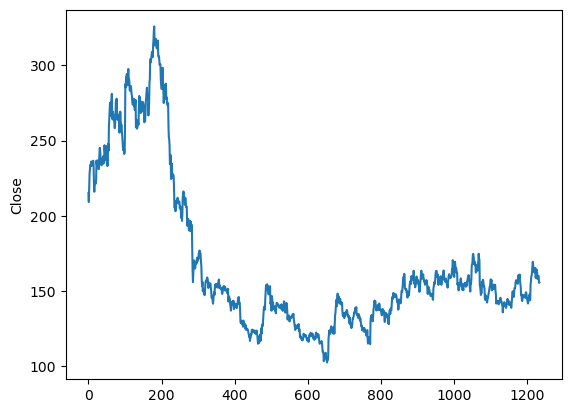

In [2]:
# load data 
import pandas as pd 
import seaborn as sns

stock_df = pd.read_csv('./NSE-TATAGLOBAL11.csv')
print(stock_df.head())

# visualize the data
sns.lineplot(data=stock_df['Close'])

In [3]:
# split data into train and test segments
print("total number of rows: ", stock_df.shape[0])
train_percentage = 0.7
stock_train = stock_df.iloc[:int(stock_df.shape[0]*train_percentage), :].Close.to_numpy()
stock_test = stock_df.iloc[int(stock_df.shape[0]*train_percentage):, :].Close.to_numpy()
print(f"Using {train_percentage*100}% of the data as training data, we have {stock_train.shape[0]} of training rows and {stock_test.shape[0]}  of testing rows.")

total number of rows:  1235
Using 70.0% of the data as training data, we have 864 of training rows and 371  of testing rows.


Unlike traditional regression problems, where we look at several feature distributions and correlations between features to create a model, time series prediction problems like this one only have one feature, time. 

Time as a feature is not very helpful at each individual timestamp. Knowing that it is `July 21, 2017, at 3:20 PM` will not help us find the stock price at this time. However, we know people make trading decisions based on events that happened recently, and existing stock prices can be decent reflections of the recent trend of trading. So if we know the stock price at `July 21, 2017, 3:20 PM`, we can probably guess the stock price at `July 21, 2017, 3:21 PM`. Thus, we can assume `local temporal dependency` and use this to make predictions. 

One approach to model this dependency is the `moving average filter`. Essentially, we average the values in a given time range close to the target timestamp, and use that as our prediction. 

Let's try this using the training dataset with different sizes. 

In [4]:
# create a moving average function 
import numpy as np 
def moving_avg(lst, size=50):
    """Moving Window Avg with a default window size of 50"""
    mov_avgs = []
    for i in range(size, len(lst)): 
        mov_avgs.append(sum(lst[i-size:i]) / size) 
    return mov_avgs

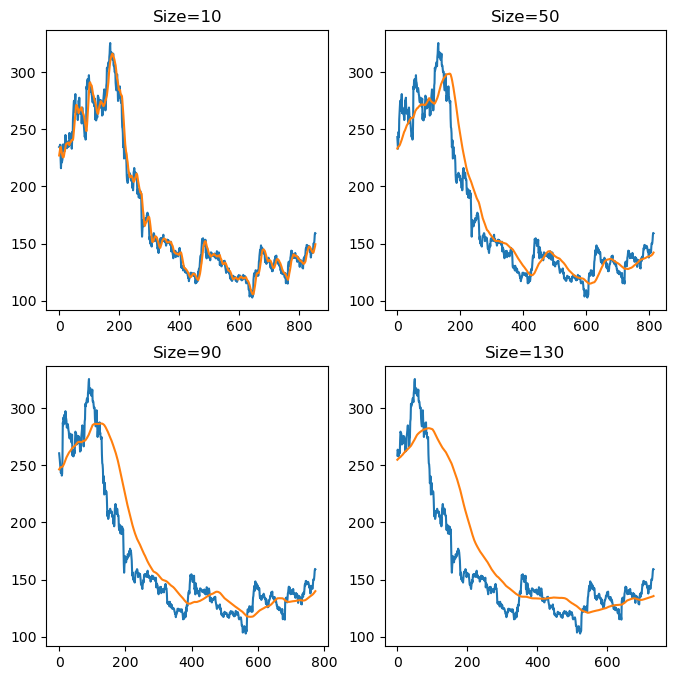

In [5]:
# visualize it against the original 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(8,8))

r,c = 0,0
for size in [10, 50, 90, 130]: 
    result = moving_avg(stock_train, size=size)
    axes[r,c].title.set_text(f'Size={size}')
    sns.lineplot(data=stock_train[size:], ax=axes[r,c])
    sns.lineplot(data=result, ax=axes[r,c])
    c+=1
    if c == 2: 
        r+=1
        c=0

The moving average method 'smoothens' the original, high-frequency curve.

From the graphs, we can also observe the effect of different window sizes. The smaller window generates a very similar curve to the original one, whereas the larger window size generates a way smoother approximation of the original.

There are advantages and disadvantages to large and small window sizes.

|              | Small                                                            | Large                                                                        |
| ------------ | ---------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| Advantage    | More accurate approximation for points closer to existing values | More generalizable approximation for an unknown time further into the future |
| Disadvantage | Not predictive of future values                                  | Less accurate                                                                |


The `moving average` is our `baseline method`. A baseline is the bare minimum we establish before we run other models, and it is going to be the model we compare our new models against.

Let's try to improve on this baseline using a `recurrent neural network` (RNN) model. More specifically, we will attempt a special RNN model, `LSTM`. 

`LSTM` takes in prices at the previous time as the input features, and use those prices to predict the current value. We will construct the training and testing set using a window method, i.e. for each data point, we use the values in the recent window as its input feature. To keep the training time down, we will use a window of size 20. 

> More on RNN and LSTM: https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e. 

In [205]:
# normalize data
"""
We want to keep the values low, but maintain their ratios. 
Smaller input values will produce smaller weights, and this will make training and storing the model easier.  
"""
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler((0,1))
norm_stock_train = mms.fit_transform(stock_train.reshape(-1,1))

mms_test = MinMaxScaler((0,1))
norm_stock_test = mms_test.fit_transform(stock_test.reshape(-1, 1))

In [206]:
# construct the feature/target pair 
import torch

size = 10
X_train, y_train = [], []
X_test, y_test = [], []
for i in range(size, len(norm_stock_train)):
    # numpy indexing
    X_train.append(norm_stock_train[i-size:i, 0])
    y_train.append(norm_stock_train[i, 0])

for j in range(size, len(norm_stock_test)): 
    X_test.append(norm_stock_test[j-size:j, 0])
    y_test.append(norm_stock_test[j, 0])

# cast back into tensor 
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)



To construct the `LSTM` model, we will be using PyTorch. 

All PyTorch network models consist of two components: the model class, and the training procedure. 

The model class will have a `__init__` method (like all python classes) and a `forward` method. `__init__` is where all the layers and utilities are initialized, and `forward` is where we define how the input is going to pass through the network. 

We define the optimization method and the loss function before training. The training process will be defined as a loop, where we will iteratively pass our input through the network model, and use the loss function and optimization method to update the model weights. 

In [207]:
# create model
import torch 
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers*x.size(0), self.hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :]) 
        return out

In [208]:
# training 
model = LSTM(input_dim=size, hidden_dim=10, output_dim=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

import time
start_time = time.time()

model.train(True)
for t in range(100):
    train_prediction = []
    running_loss, counter = 0, 0
    for x, y in zip(X_train, y_train): 
        y_train_pred = model(x.reshape(1, -1))
        train_prediction.append(y_train_pred)
        loss = criterion(y_train_pred, y.reshape(1, -1))
        running_loss += loss.item()
        counter += 1
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print("Epoch ", t, "MSE: ", running_loss/counter)
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.037967865474497285
Epoch  1 MSE:  0.002848463540576978
Epoch  2 MSE:  0.0023889470049404814
Epoch  3 MSE:  0.0022668289739163627
Epoch  4 MSE:  0.0022499386528274366
Epoch  5 MSE:  0.0022641335800047497
Epoch  6 MSE:  0.002275119347843951
Epoch  7 MSE:  0.002270371189663667
Epoch  8 MSE:  0.0022456391657442528
Epoch  9 MSE:  0.002198358071298365
Epoch  10 MSE:  0.002128504332061262
Epoch  11 MSE:  0.002051320387680104
Epoch  12 MSE:  0.0019718299309449184
Epoch  13 MSE:  0.0018961992578570305
Epoch  14 MSE:  0.001810346860322014
Epoch  15 MSE:  0.0017632242637079017
Epoch  16 MSE:  0.0017064105993328871
Epoch  17 MSE:  0.0016333934563257015
Epoch  18 MSE:  0.0015629473581142577
Epoch  19 MSE:  0.001494322537389865
Epoch  20 MSE:  0.001436867569646586
Epoch  21 MSE:  0.0013908710283444667
Epoch  22 MSE:  0.0013506829524135633
Epoch  23 MSE:  0.0013119846257534462
Epoch  24 MSE:  0.0012798844768082897
Epoch  25 MSE:  0.0012475532148172991
Epoch  26 MSE:  0.00121541192766

In [209]:
# evaluation 
model.train(False)
test_predictions = []
running_loss, counter = 0, 0
for x, y in zip(X_test, y_test): 
    y_test_pred = model(x.reshape(1, -1))
    test_predictions.append(y_test_pred.detach().item())
    loss = criterion(y_train_pred, y.reshape(1, -1))
    running_loss += loss.item()
    counter += 1
    
print("MSE: ", running_loss/counter)

MSE:  0.08450010974952432


<AxesSubplot: >

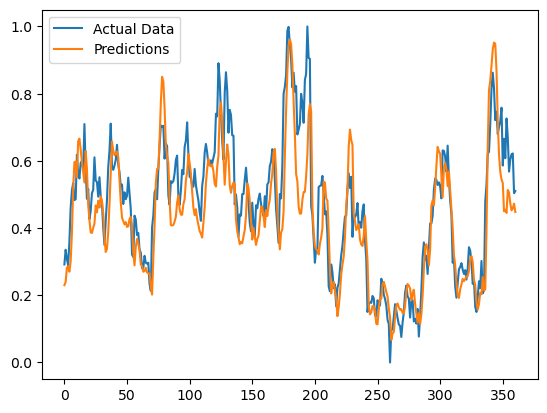

In [210]:
# visualize result 
sns.lineplot(data=y_test, label='Actual Data')
sns.lineplot(data=test_predictions, label='Predictions')

The final MSE, after several runs, hovers around 0.08-0.1. Keep in mind this is the normalized value (all values are between 0,1) so the loss value is not representative of the actual value (i.e. the is not how much money you are going to lose). 

> If you want to see the real error value, you can use the function, `MinMaxTransformer.inverse_transform()`, to get the original value back. 

Looking at the visualization, we can see with only 100 epochs of training, the LSTM model is able to correctly predict the trend of the price change. This shows that this isn't a bad model. 

## Image Classification 

Image classification is usually the first thing people think of when taking about computer vision, and we can see image classification model at work on a daily basis. For the second example, we will construct an effective image classification model to identify hand written digits from their picture. 

## Housing Listing Anomaly Detection




Spotify Example: https://towardsdatascience.com/unsupervised-anomaly-detection-on-spotify-data-k-means-vs-local-outlier-factor-f96ae783d7a7
